# ベイズ推定

ポイント
- 結果から原因を推定するヤバイやつ
- この感覚になれること自体が結構つらい

前提知識
- 確率についての知識・感覚

以降の話の想定
- 時刻とセンサーデータがひたすら並んでいるデータセットを使う
- センサーは距離センサー（1点だけ出力するURG)
- 壁から600mmくらい話して，静止させた状態で3日間くらい収録し続けた

In [38]:
import sys
sys.path.append('../src')

import bayes_estimation_helper
import importlib
importlib.reload(bayes_estimation_helper)
import matplotlib.pyplot as plt
import seaborn as sns

# データをロードする
# このデータは，センサーを静止させた状態で得られたもの
# データのフォーマットはこんな感じ
# date time ir lidar
# 20200219 1230 345 612
# ...
# ..
# .

# このクラスでは，同時確率を計算し，必要に応じて加工する機能が実装されている
helper = bayes_estimation_helper.SensorValueAndTimeWithBayes('../data/range_sensor/sensor_data_600.txt')

shape of joint_z_t = (37, 24)
sum of joint_z_t = 0.9999999999999999


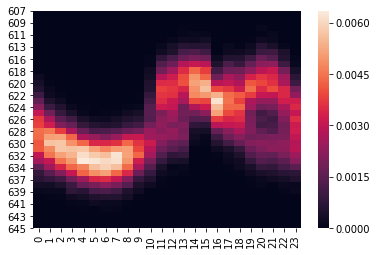

In [39]:
# 同時確率P(z, t)を試しに表示する
# なお，時間tはhour毎になるように計算されている
joint_z_t = helper.joint_z_t()
print('shape of joint_z_t = {}'.format(joint_z_t.shape))
print('sum of joint_z_t = {}'.format(joint_z_t.sum().sum()))
sns.heatmap(joint_z_t)
plt.show()

午前と午後でなんか傾向が違うようなデータになっていることが確認できる

このように，センサの特性は実験することで見えてくる


次に，周辺化について考える

これは，zまたはtに注目して確率を丸めるような感じ

とりあえずtについて周辺化をする

各列(t)毎に，確率の総和を計算し，P(z, t) -> P(t)にする

$$
P(t) = \sum_{z}P(z, t)
$$

shape = (24,)
sum = 0.9999999999999999
0     0.043013
1     0.042916
2     0.042879
3     0.042916
4     0.042964
5     0.043037
6     0.043061
7     0.043001
8     0.038712
9     0.028651
10    0.028736
11    0.043098
12    0.043146
13    0.043025
14    0.043183
15    0.043122
16    0.043061
17    0.043122
18    0.043049
19    0.043086
20    0.043159
21    0.042976
22    0.043049
23    0.043037
Name: 0, dtype: float64


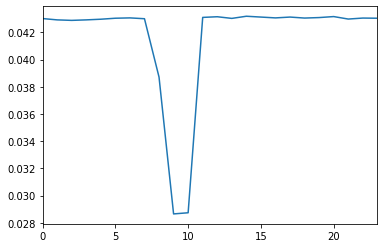

In [40]:
p_t = helper.marginalize_in('t')
print('shape = {}'.format(p_t.shape))
print('sum = {}'.format(p_t.sum()))
print(p_t)
p_t.plot()
plt.show()

センサの値については，総和にしてしまっているため，具体的な値の情報は失われる．

しかし，時間についての情報は見やすくなる

例えば，この同時確率分布のデータから適当にセンサー値を引っ張ってきたときに，

どの時間帯のデータが得られやすいのかというもの

このデータは，何らかの理由で9時，10時あたりのデータ数が少ないようだ

次に条件付き確率分布について見ていく

計算方法としては，

$$
P(z \mid t) = \frac{P(z, t)}{P(t)}
$$

shape of cond_z_t = (37, 24)
sum of cond_z_t = 24.0
sum of cond_z_t[0] = 1.0000000000000002


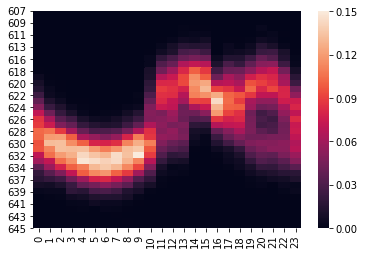

In [41]:
cond_z_t = helper.cond_z_t()
print('shape of cond_z_t = {}'.format(cond_z_t.shape))
print('sum of cond_z_t = {}'.format(cond_z_t.sum().sum()))
print('sum of cond_z_t[0] = {}'.format(cond_z_t[0].sum()))
sns.heatmap(cond_z_t)
plt.show()

この分布の単純な総和(sum of cond_z_t)が1.0ではないことに注目してほしい

もともと総和が1.0の確率分布に何らかの四則演算を施しているので，1.0にならないのは当たり前

そして，列0の総和(sum of cond_z_t(0))が1.0になり，新たな確率分布をなしていることがわかる

試しにプロットしてみよう

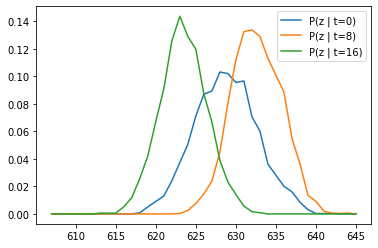

In [42]:
# 3つの時刻をピックアップ
ts = [0, 8, 16]

for t in ts:
    plt.plot(cond_z_t[t], label='P(z | t={})'.format(t))

plt.legend()
plt.show()

時刻を絞ると，時刻によって変化していたセンサ値zの振る舞いが，すなおな正規分布になる

(ならない時間帯もありそうだけど，それは時間以外の要因が考えられる．今回は，あらゆることを時間のせいにしている）

で，結局ロボティクスにとって，何が嬉しいのかについて

これまでやってきたのは

- 同時確率$P(z, t)$を加工し
- 時刻tに注目した周辺確率$P(t)$を取り出し
- tを指定すればどんなセンサ値zが得られやすいかがわかる条件付き確率$P(z \mid t)$を得た

今回の例では，明らかに時間tがセンサ値zに影響を与えている

(センサ値zが変化しても，時間tは変わらないよね)

ということで，原因は時間tで，結果がセンサ値zという関係にある

そして，同時確率は入れ替えても同じ値になるので，こんなこともできる

- 同時確率$P(t, z)$を加工し
- センサ値zに注目した周辺確率$P(z)$を取り出し
- zを指定すればどんな時刻tっぽいのかがわかる条件付き確率$P(t \mid z)$が得られる

つまり

$$
P(z \mid t) = \frac{P(z, t)}{P(t)}
$$
$$
P(t \mid z) = \frac{P(t, z)}{P(z)}
$$

変形して

$$
P(z, t) = P(z \mid t)P(t)
$$
$$
P(t, z) = P(t \mid z)P(z)
$$

同時確率分布は同じなので，ちょっと整理すると，

$$
P(t \mid z) = \frac{P(z \mid t)P(t)}{P(z)}
$$

となる．

センサ値がzとなったとき，時刻がtである確率が計算できる

つまり，結果から原因を推定することができるようになる

これはベイズの定理と呼ばれる

ロボティクスでは，センサ値から，原因（ロボットの姿勢など）を推定する問題に使われたりする

今回は，条件付き確率$P(z \mid t)$と周辺確率$P(t)$が既知な状態

それらを使って，時刻を推定してみる

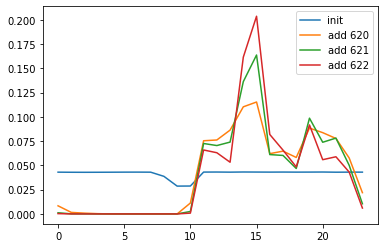

In [47]:
importlib.reload(bayes_estimation_helper)
from bayes_estimation_helper import BayesianFilter
import copy

# ベイズ推定クラス
# 上記の計算式が実装されている
# 条件付き確率P(z | t)をメンバ変数として保持する
bf = BayesianFilter(cond_z_t)

# 周辺確率P(t)を初期値とする
# 推定器によって更新される
# 以前計算したものをコピーして使うことにする
p_t_z = copy.deepcopy(p_t)

# とりあえず，初期状態をplotしておく
plt.plot(p_t_z, label='init')

# 与えるセンサ値z
# あえて，15時台のものを用意する
zs = [620, 621, 622]

# それらが観測されたと思われる時間を推定する(15時あたりがピークだと良いな)
for z in zs:
    # P(t | z)を更新する
    # 中でやっているのは
    # P(z | t)P(t)を計算し
    # P(z)を求め(↑の総和)
    # P(t | z)を計算する
    # 次のループでは，更新されたものを与え，さらに更新する
    p_t_z = bf.update(z, p_t_z)
    plt.plot(p_t_z, label='add {}'.format(z))
plt.legend()
plt.show()

センサ値を与えると，都度分布が変わることがわかる

とりあえず，

- 0~10時の確率はかなり低いだろう
- 15~16時あたりの確率が高いだろう

と推定クラスは言っている

このように，センサ値(結果)から，時刻(原因)の推定ができることがわかる

shape = (37,)
sum = 1.0
607    0.000012
608    0.000049
609    0.000061
610    0.000328
611    0.000680
612    0.001580
613    0.004241
615    0.007752
616    0.013852
617    0.022053
618    0.031628
619    0.040498
620    0.046585
621    0.050947
622    0.051980
623    0.049319
624    0.046354
625    0.041725
626    0.042648
627    0.043645
628    0.050996
629    0.060121
630    0.066949
631    0.070048
632    0.066901
633    0.059623
634    0.047776
636    0.035370
637    0.022260
638    0.012819
639    0.006671
640    0.002989
641    0.000996
642    0.000401
643    0.000109
644    0.000024
645    0.000012
Name: 0, dtype: float64


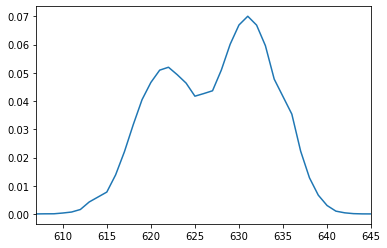

In [31]:
p_z = helper.marginalize_in('z')
print('shape = {}'.format(p_z.shape))
print('sum = {}'.format(p_z.sum()))
print(p_z)
p_z.plot()
plt.show()

shape of cond_t_z = (24, 37)
sum of cond_t_z = 37.0
sum of cond_t_z[0] = 1.0


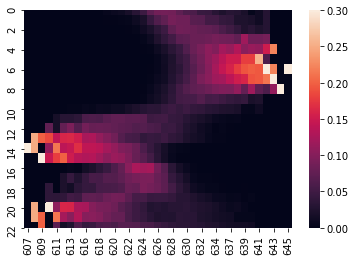

In [32]:
cond_t_z = helper.cond_t_z()
print('shape of cond_t_z = {}'.format(cond_t_z.shape))
print('sum of cond_t_z = {}'.format(cond_t_z.sum().sum()))
print('sum of cond_t_z[0] = {}'.format(cond_t_z[607].sum()))
# 分布が見えやすいように0.3で飽和させている
sns.heatmap(cond_t_z, vmax=0.3)
plt.show()

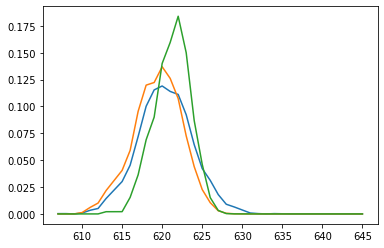

In [44]:
importlib.reload(bayes_estimation_helper)
from bayes_estimation_helper import BayesianFilter
import copy
bf = BayesianFilter(cond_t_z)
updated_p_z = copy.deepcopy(p_z)
# 15時前後の時間を与えて，その時観測されやすいセンサ値を推定する(622付近だと上記と整合する)
for t in [14, 15, 16]:
    updated_p_z = bf.update(t, updated_p_z)
    plt.plot(updated_p_z)
plt.show()